In [150]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import timeit
import copy

In [151]:
# Funciones auxiliares

# Función log-energy. La entrada es una configuración de puntos en la esfera w
def log_energy(w):
  w=np.array(w)
  n=len(w)
  f = 0
  for i in range(n):
    Di = w - w[i,:]
    di = np.sqrt(np.sum(Di**2,axis=1))
    di[i] = 1
    f += np.sum(-np.log(di))
  return 0.5*f

# Plotea la configuración de puntos z en la esfera unidad
def plot_points(z):
  pi = np.pi
  cos = np.cos
  sin = np.sin
  phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
  xx = sin(phi)*cos(theta)
  yy = sin(phi)*sin(theta)
  zz = cos(phi)
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_surface(xx, yy, zz,  rstride=1, cstride=1, color='c', alpha=0.5, linewidth=0.5)
  ax.scatter(z[:,0],z[:,1],z[:,2])

In [152]:
#parte 1: Implementar el gradiente para un xi y para una configuracion de x

def grad_E_puntual(x,i):
    N = len(x)
    grad = np.zeros_like(x)
    for j in range(N):
      if(i!=j):
        for k in range(3):
          norm_diff = np.linalg.norm(x[i] - x[j], 2)
          grad[i][k] += -1 * (x[i][k] - x[j][k]) / (norm_diff**2)
    return grad[i]


def grad_E(x):
    N = len(x)
    grad = np.zeros_like(x)
    for i in range(N):
        for j in range(N):
            if(i!=j):
              for k in range(3):
                norm_diff = np.linalg.norm(x[i] - x[j], 2)
                grad[i][k] += -1 * (x[i][k] - x[j][k]) / (norm_diff**2)

    return grad


In [153]:
# Parte 2 : GRADIENTE PROYECTADO PARA HALLAR MIN LOCAL DE E(Xi)

#Definimos proj(x)
def proj(x):
  if la.norm(x) != 1 :
    x = x/la.norm(x)

  return x

def proj_grad_desc(x2, proj, alpha, s, tol1=1e-5, tol2=1e-5) :
  es2 = []
  es2.append(log_energy(x2))

  x_ant = x2.copy()
  x_techo = np.zeros_like(x2)

  flag = True
  it = 0
  it2 = 0
  N = len(x2)

  while (flag or la.norm(x_ant-x2) >= tol1): #Verifico la configuración de puntos total
    flag = False #En la primer it por def x_ant = x2, lo arreglo forzando la primer entrada
    x_ant = x2.copy()
    for i in range(N): #Recorro todos los puntos
        x_techo[i] = proj(x2[i] - s*grad_E_puntual(x2,i))
        x2[i] = x2[i] + alpha*(x_techo[i] - x2[i])
        it = it + 1

    es2.append(log_energy(x2))
    it2 = it2 + 1 #Número de veces que se chequea toda la configuración de puntos


  return x2, it, it2, np.array(es2)

In [154]:
# Parte 3

def proj_grad_desc_total(x3, proj, alpha, s, tol1=1e-5, tol2=1e-10) :
  es3 = []
  es3.append(log_energy(x3))

  x_ant = x3.copy()
  x_techo = np.zeros_like(x3)

  flag = True
  it = 0
  it2 = 0
  N = len(x3)

  while  (flag or la.norm(x_ant-x3) >= tol1):
    flag = False
    x_ant = x3.copy()
    gradiente = grad_E(x3)
    for i in range(N):
        x_techo[i] = proj(x3[i] - s*gradiente[i])
        x3[i] = x3[i] + alpha*(x_techo[i] - x3[i])
        it = it + 1

    es3.append(log_energy(x3))
    it2 = it2 + 1

  return x3, it, it2, np.array(es3)

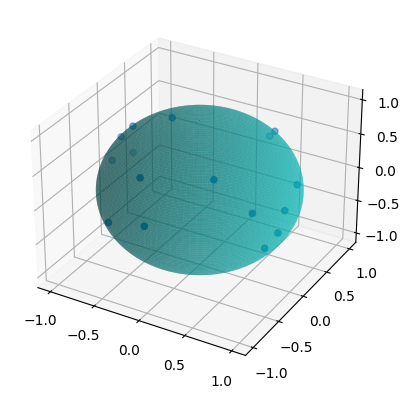

In [155]:
#Análisis Parte 2 y Parte 3:

N=16 # cantidad de puntos
#configuracion de puntos. Cada fila es un punto
X0 = np.random.randn(N,3)
X0 = X0 / np.linalg.norm(X0, axis=-1)[:, np.newaxis]

plot_points(X0)

Testeo punto 2: 
Energía logaritmica para la configuración de puntos final: 
-36.10614959673738
Número de iteraciones sobre los puntos: 
48080
Número de iteraciones sobre toda la configuración de puntos: 
3005
Tiempo de ejecución: 
24.342012228000385


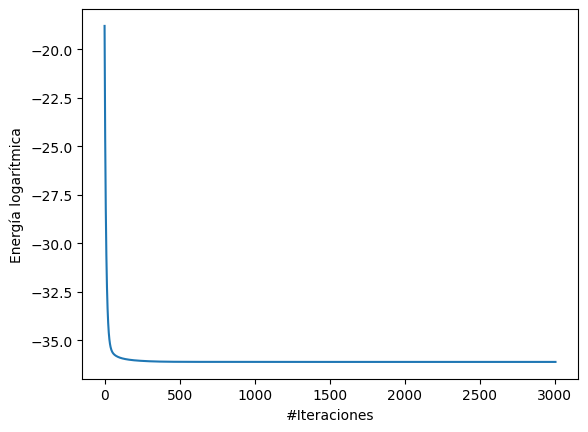

In [156]:
print("Testeo punto 2: ")
start = timeit.default_timer() #Inicia el timer
x2, iter, iterSeg, es2 = proj_grad_desc(X0.copy(), proj, alpha=0.1, s=1, tol1=1e-5, tol2=1e-5)
stop = timeit.default_timer() #Finaliza el timer
print("Energía logaritmica para la configuración de puntos final: ")
print(es2[-1])

print("Número de iteraciones sobre los puntos: ")
print(iter)

print("Número de iteraciones sobre toda la configuración de puntos: ")
print(iterSeg)

print("Tiempo de ejecución: ")
print(stop - start)

plt.xlabel('#Iteraciones')
plt.ylabel('Energía logarítmica')
plt.plot(es2)

Configuración de puntos final en la esfera: 


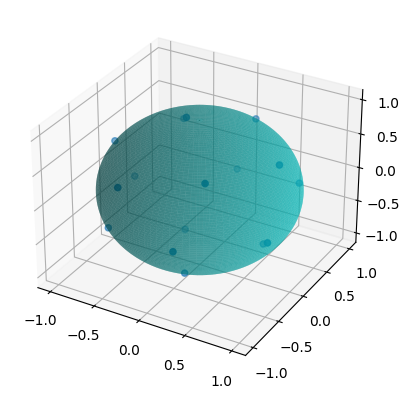

In [157]:
print("Configuración de puntos final en la esfera: ")
plot_points(x2)

Testeo punto 3: 
Energía logaritmica para la configuración de puntos final: 
-36.106152138444315
Número de iteraciones sobre los puntos: 
7536
Número de iteraciones sobre toda la configuración de puntos: 
471
Tiempo de ejecución: 
4.688363720999405


Text(0, 0.5, 'Energía logarítmica')

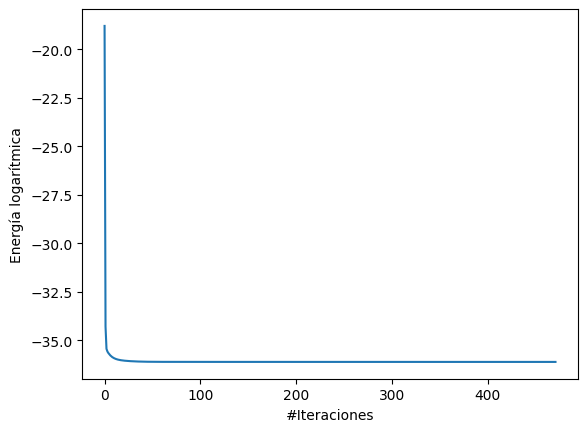

In [158]:
print("Testeo punto 3: ")
start = timeit.default_timer() #Inicia el timer
x3, it, itSeg, es3 = proj_grad_desc_total(X0.copy(), proj, alpha=1, s=1.5, tol1=1e-5, tol2=1e-5)
stop = timeit.default_timer() #Finaliza el timer
print("Energía logaritmica para la configuración de puntos final: ")
print(es3[-1])

print("Número de iteraciones sobre los puntos: ")
print(it)

print("Número de iteraciones sobre toda la configuración de puntos: ")
print(itSeg)

print("Tiempo de ejecución: ")
print(stop - start)

plt.plot(es3)
plt.xlabel('#Iteraciones')
plt.ylabel('Energía logarítmica')

Configuración de puntos final en la esfera: 


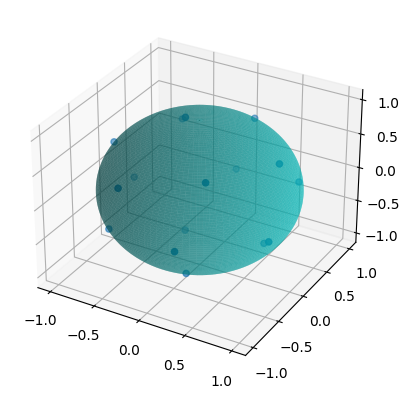

In [159]:
print("Configuración de puntos final en la esfera: ")
plot_points(x3)